<h1><center> Traffic Accidents in the USA (2016 to 2019)</center></h1>

Traffic accidents are often a frequent reminder of the daily dangers of travelling. In the USA alone, there are currently 222 million people registered with a drivers licence as of 2016 [Link](https://www.statista.com/topics/1197/car-drivers/), there are about 0.2 deaths per 10 billion passenger-miles [Link](https://www.bts.gov/archive/publications/transportation_statistics_annual_report/2015/tables/ch6/table6_1). 


For my analysis, I utilised three sources of data. 
- US Accidents (3.0 million records) from Kaggle.com.  [Link](https://www.kaggle.com/sobhanmoosavi/us-accidents)
- "Seat belts laws in United States" from Wikipedia.  [Link](https://en.wikipedia.org/wiki/Seat_belt_laws_in_the_United_States)
- TMC Event Codes from OpenStreetMap. [Link](https://wiki.openstreetmap.org/wiki/TMC/Event_Code_List)

In this notebook, I will describe how I processed the data, the questions I asked and answered throughout the process and given more time, what I'd like to explore further in the future.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
from scipy.stats import norm
from scipy.stats import t
from scipy import stats
from sklearn import preprocessing
from IPython.display import Image
pd.set_option('display.max_columns', None)

In [ ]:
data = pd.read_csv("../input/us-accidents/US_Accidents_Dec19.csv")

### Part One - Data Preparation and Cleaning

After importing the appropiate libraries such as Pandas, Numpy, Matplotlib, Seaborn and Scipy,
I imported the dataset to get an idea of what I'm working with. The dataset was one of the biggest
I've worked with yet (1gb), three million rows and 49 columns.

In [ ]:
data.head()

I began by converting the relevant columns to the correct datatype. 

In [ ]:
data['Start_Time'].dtypes

Here, I convert the entire Start Time column to a datatime format. I also normalize the
datetime to remove the hours / minutes / seconds elements as it is not required for 
all of the data analysis I planned. However, in some instances I bypass this function. 

In [ ]:
data['Start_Time'] = pd.to_datetime(data['Start_Time'])
data['Start_Time'] = data['Start_Time'].dt.normalize()
data['Start_Time'].dtypes

Here, I drop the majority of the columns I don't wish to investigate. This will made the dataset more
managable and less cumbersome to work with!

In [ ]:
data.columns

In [ ]:
data_clean = data.drop(columns = ['End_Time', 'Temperature(F)', 'Wind_Chill(F)', 
                                  'End_Lat', 'End_Lng', 
                                  'Humidity(%)', 'Pressure(in)',
                                   'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
                                   'Precipitation(in)','Amenity', 'Bump', 'Crossing', 'Number',
                                  'Street', 'Side', 'City', 'County', 'State',
                                   'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
                                   'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
                                   'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
                                   'Astronomical_Twilight', 'Timezone','Airport_Code','Weather_Timestamp' ])

Below, we count the number of NaN values present in our dataset. There's quite a few! However, thankfully given the size of our dataset, we can drop these from the set and focus on the values that we have.

In [ ]:
data_clean.isnull().sum()

### Part Two - Sorting, Analysing

Here, I selected the dataframe so it's over a three year period. 

In [ ]:
data_year = data[(data['Start_Time'] > '2016-08-23') &
                (data['Start_Time'] <= '2019-08-23')]

Next, I was interested in the meaning of the TMC column, and decided to utilise the TMC Event Codes from OpenStreetMap

In [ ]:
traffic_codes = data['TMC'].value_counts()
traffic_codes = pd.DataFrame(traffic_codes)
traffic_codes.reset_index()
traffic_codes.index.names = ['Code']
traffic_codes.head()

In [ ]:
event_codes = pd.read_html('https://wiki.openstreetmap.org/wiki/TMC/Event_Code_List')

In [ ]:
codes = event_codes[0].drop(columns = ['N','Q','T','D','U','C','R'])

In [ ]:
codes.head()

In [ ]:
df_codes = codes.merge(traffic_codes, left_on='Code', right_on='Code')
df_codes = df_codes.rename(columns = {'TMC':'# of Accidents'})

Whilst given that this is an accident dataset and that the most common description of the accident is "(Q) Accident(s)" is unsurprising, it's interesting to denote the use of the TMC as a way of providing quick information the to Police, Emergency Services etc. It also gives valuable traffic data in some instances such as how the road is affected.

In [ ]:
df_codes.sort_values(by = '# of Accidents',ascending = False)

Below I've grouped the number of accidents that occur each day by their Severity.

In [ ]:
severity_time = data_year[['Severity','Start_Time']]
severity_time['Start_Time'] = severity_time['Start_Time'].dt.date
sev_count = severity_time.groupby(severity_time['Start_Time'])['Severity'].value_counts()
sev_count = severity_time.groupby(severity_time['Start_Time'])['Severity'].value_counts().unstack(level = 1)
sev_count.reset_index(level=0, inplace=True)
sev_count.head()

In the following cells I group together data by state, severity, begin by correlating the Seatbelt useage data. One issue I overcame was that our Accidents data sets only express the names of states as their abbreviations, thus I matched the seatbelt datasets by merging datasets together in order to obtain the fullname, abbreviation, severity and seatbelt data into one set.

In [ ]:
accidents_by_state = [data_year[data_year['State'] == i].count()['ID'] 
                      for i in data_year.State.unique()]
accidents_by_state.sort(reverse = True)
states = data_year.State.unique()
state_severity = data_year[['Severity', 'ID', 'State']]
grouped = state_severity.groupby(['State']).sum().reset_index()
sort_grouped = grouped.sort_values(by = 'Severity', ascending = False)
sort_grouped.head()

Here I import the data from the Wikipedia page which contains all the North American States, their long names and abbreviations. 

In [ ]:
stateabbr = pd.read_html('https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States')[0]
stateabbr.head()

In [ ]:
state_list = stateabbr.values
state_list = pd.DataFrame(state_list)
state_list = state_list[[0,1]]
state_list = state_list.rename(columns = {0:'Long',1:'State'})
state_list.head()

Now, I import the Seatbelt data, clean it and begin to merge it with the State information.

In [ ]:
df = pd.read_html('https://en.wikipedia.org/wiki/Seat_belt_laws_in_the_United_States')[0]
df = df.drop(['Type of law','Date of first law','Who is covered','Base fine before fees'], axis = 1)
df = df.rename(columns = {'State, federal district, or territory':'State','Seat Belt Usage (2017)[7][note 2]':'Seatbelt'})
df = df.drop(52) ### Wake Island has no data.
df.sort_values(by = 'Seatbelt', ascending = False).head()

In [ ]:
df_states = sort_grouped.merge(state_list, left_on='State', right_on='State')
df_states = df_states.rename(columns = {'State':'Abbv','Long':'State'})
df_states.head()

In [ ]:
df_states_full = df_states.merge(df, left_on = 'State', right_on='State')
df_states_full = df_states_full[['Abbv','State','Severity','Seatbelt']]
df_states_full['Seatbelt'] = df_states_full['Seatbelt'].str.replace('%','')
df_states_full.sort_values(by = 'Severity', ascending = False).head()

Finally, I clean the data and convert the values to the correct types.

In [ ]:
df_states_full.Seatbelt = df_states_full.Seatbelt.astype(str).astype(float)
df_states_full.dtypes

For data visualization purposes, I created a dataframe which contains the states and their respective number of accidents.

In [ ]:
top_grouped = state_list.merge(sort_grouped, left_on='State', right_on='State')
top_grouped = top_grouped.sort_values(by = 'Severity', ascending = False)
top_grouped.Long = top_grouped.Long.str.replace(("[['E']]"),"")
top_grouped.head()

### Part Three: Data Visualisation

#### Accident Location Analysis

The dataset provided Longtitude and Latitude information for every single accident. I decided to use this information, combined with Tableau to produce a heatmap illustrating where the most accidents took place.

In [ ]:
Image("../input/tableauimages/download.png")

As you can see, most traffic accidents tend to be along the West or East Coasts, centering typically around bigger cities.
It makes sense to further analyse this, so using the data I grouped together earlier, we began visualising the number of accidents by state.

In [ ]:
sns.set(style="white", context="talk")

fig, ax = plt.subplots(figsize=(16,10)) 
sns.barplot(x = top_grouped['Severity'], y = top_grouped['Long'].head(10))
plt.xticks(rotation=90)
plt.yticks(fontsize = 20)
plt.title('Top 10 # of Accidents by State Aug 2016 - Aug 2019', fontsize = 30)
plt.xlabel('# of Accidents', fontsize = 20)
plt.ylabel('State', fontsize = 20)

The plot above demonstrates that the greatest number of accidents, irregardless of severity, take place in California, Texas and Florida.
However, further filtering of the data reveals some interesting insights.

In [ ]:
severities4_state = data[data['Severity'] == 4]['State'].value_counts()
severities3_state = data[data['Severity'] == 3]['State'].value_counts()
severities2_state = data[data['Severity'] == 2]['State'].value_counts()
severities1_state = data[data['Severity'] == 1]['State'].value_counts()
names = ['Severity 4', 'Severity 3', 'Severity 2', 'Severity 1']

In [ ]:
sever_df = pd.concat([severities4_state, severities3_state,
                     severities2_state, severities1_state],
                    axis = 1)
sever_df.columns = names
sever_df.head(10)
sever_df.fillna(0)
sever_df.reset_index(inplace = True)
sever_df = sever_df.rename(columns = {'index':'State'})
sever_df = sever_df.fillna(0)
sever_df_sort = sever_df.sort_values(by = 'Severity 4', ascending = False)

#### As you can see above, Severity 4 accidents occur most frequently in Flordia, Georgia and California.

In [ ]:
plt.figure(figsize=(16, 10))
ax = sever_df_sort.plot(x = 'State', y = 'Severity 4', kind = "bar", figsize = (16,10))
plt.show

#### Weather Analysis

Here, I used Seaborn to plot the Top 10 most common Weather Conditions at the time of an accident. Suprisingly "clear" weather conditions were most commonly reported when an accident took place. 

In [ ]:
sns.set(style="white", context="talk")

fig, ax = plt.subplots(figsize=(16,10)) 
data_year['Weather_Condition'].value_counts().head(10).plot.bar(color = ['coral', 
                                                                         'darkorange',
                                                                         'limegreen', 
                                                                         'navy', 
                                                                         'orchid',
                                                                         'slateblue',
                                                                        'teal',
                                                                        'royalblue',
                                                                        'lightsteelblue',
                                                                        'darkblue'],
                                                               alpha = 0.75)
plt.xlabel('Weather Condition', fontsize = 20)
plt.ylabel('# of Accidents', fontsize = 20)
ax.tick_params(labelsize= 15)
plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.title('Most Common Weather Conditions at the time of Accident', fontsize = 25)

#### Time of Day Analysis 

Following our analysis of the weather data, I decided to investigate if time of day has an effect on both accident severity and the number of accidents.

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(sev_count.Start_Time, sev_count[1], label = 'Severity 1', markevery = 5)
plt.plot(sev_count.Start_Time, sev_count[2], label = 'Severity 2', markevery = 5)
plt.plot(sev_count.Start_Time, sev_count[3], label = 'Severity 3', markevery = 5)
plt.plot(sev_count.Start_Time, sev_count[4], label = 'Severity 4', markevery = 5)

plt.xlabel('Date')
plt.ylabel('# of Accidents')
plt.title('# of Accidents by Severity against Time')
plt.legend()
plt.show()

This rather spikey graph illustrates the number of accidents against the timeframe we are investigating, catagorised by the severity. 

As you can see from the above plot, the greatest number of accidents are considered Severity 2, followed by Severity 3 and 4. There are barely any Severity 1 accidents, as this suggests that perhaps the definition of an accident isn't always clear and perhaps many are unreported.

Here, I zoom in on a smaller timeframe to investigate the nature of the peaks and troughs. 

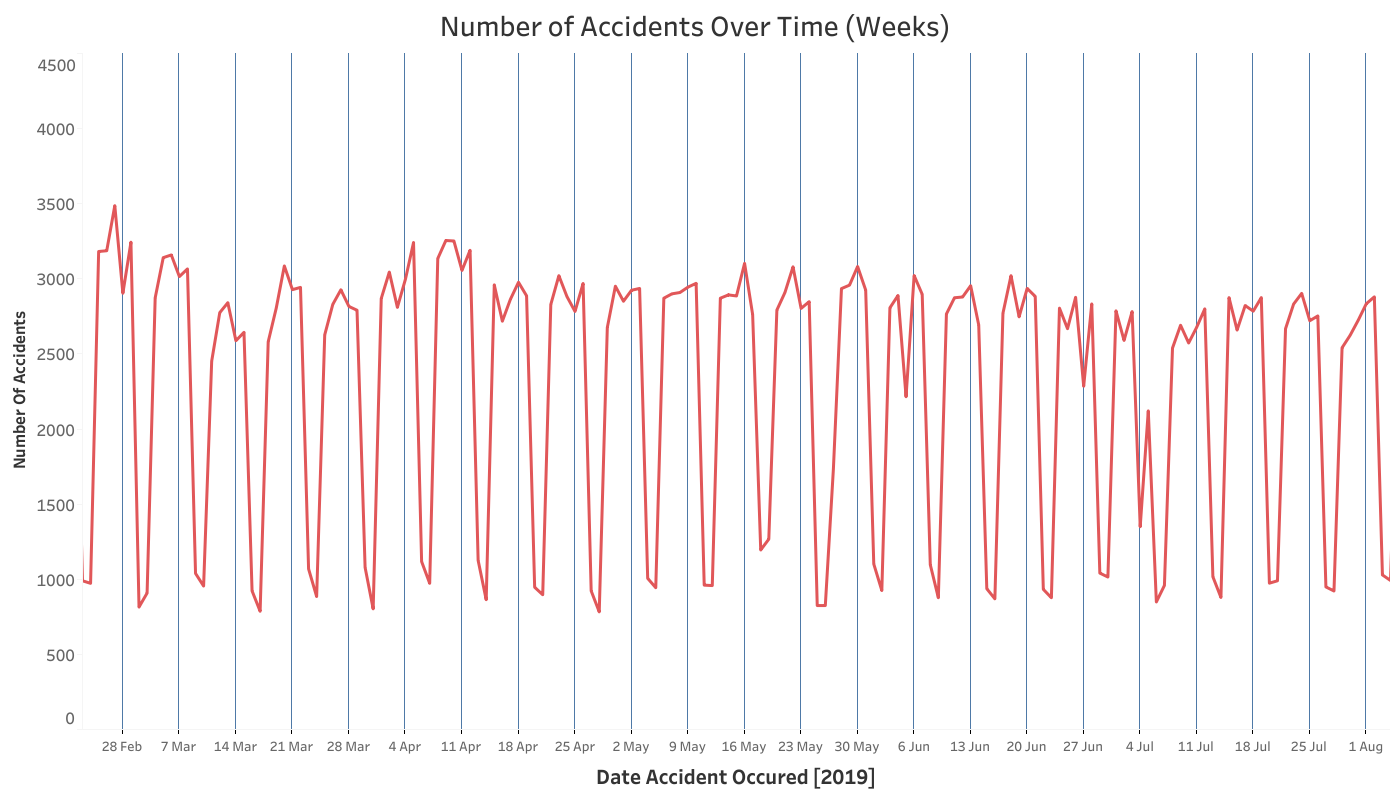

From checking my calendar, I was able to see that the peaks and dips corresponding to weekdays and weekends respectively. This makes sense as less people tend to travel on the weekend and perhaps drivers are in less of a rush to get to work. If we zoom in further, perhaps we can see this better.

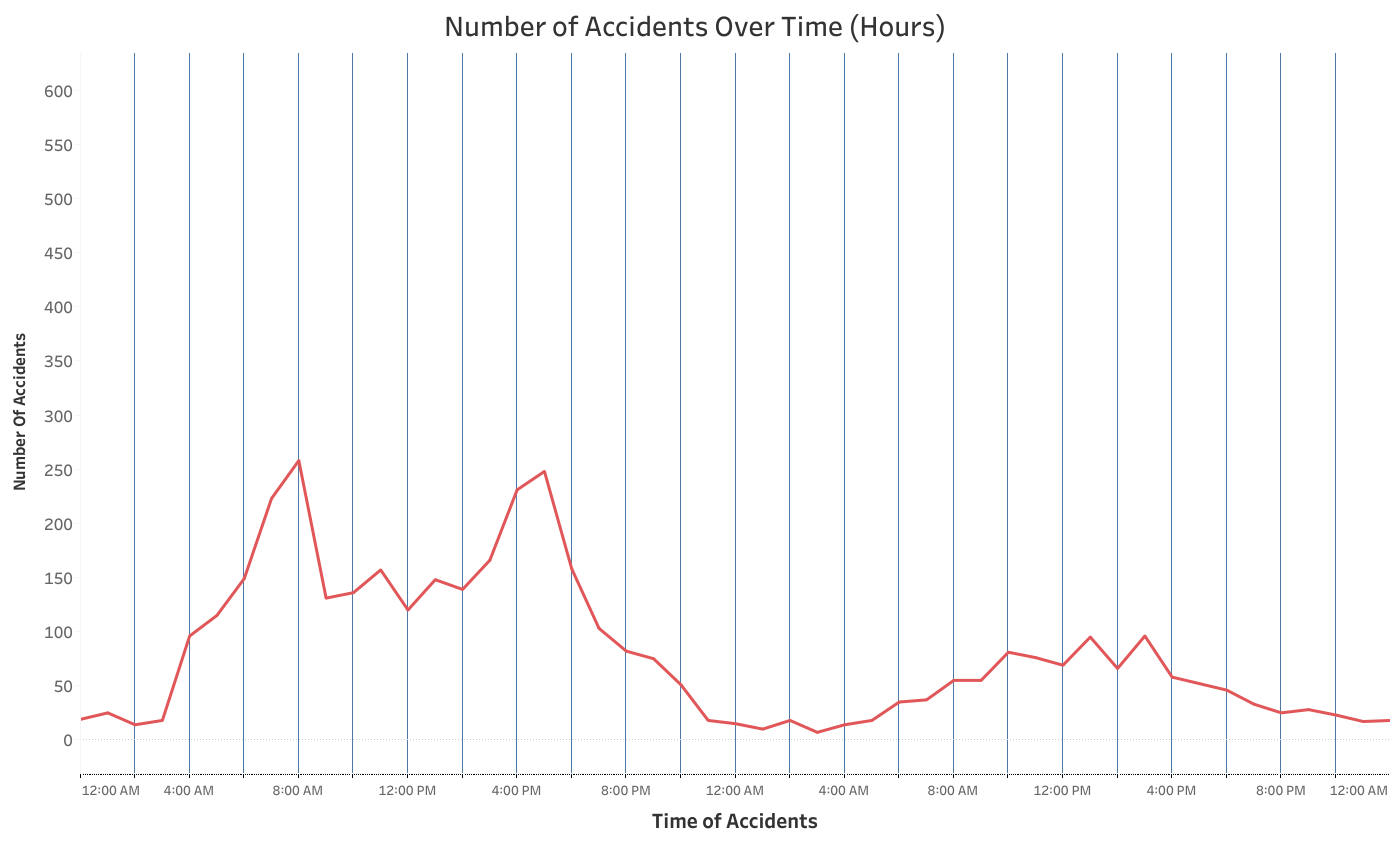

As we stipulated, around 8pm and 5pm, the greatest number of accidents occurs. We can attribute this perhaps to rush hour. On the right side of the graph, we can see the effect that a weekend has on the number of accidents.

### Part 5: Correlation

In order to investigate further, I analysed the data set by using "GetDummies". Get Dummies converts categorical data into 1's or Zero's. This allows us to make a correlation between a piece of data that was previously assigned to a string, and a numeric value (Severity)

Firstly, we needed to do some cleaning of the data. In the Weather Conditions column, frequently those describing the weather would collate weather types together, for example "Sand / Dust Whirlwinds / Windy", thus this would result errors in our data. Thus, using string splicing on the "/", we're able to seperate out all the weather conditions into their own individual column.

In [ ]:
data_year['Weather_Condition 1'] = data_year['Weather_Condition'].str.split('/').str[0].str.strip()
data_year['Weather_Condition 2'] = data_year['Weather_Condition'].str.split('/').str[1].str.strip()
data_year['Weather_Condition 3'] = data_year['Weather_Condition'].str.split('/').str[2].str.strip()

In [ ]:
data_year.head()

Let's see if it worked.

In [ ]:
data_year.loc[data_year['Weather_Condition'] == 'Sand / Dust Whirlwinds / Windy']

Following this, we merge the Severity and the Weather Conditions 1, 2, 3 into a new dataset, from which we can create dummies. We also drop nan's and clean data while we're at it.

In [ ]:
df_unmerged = data_year[['Severity',
                         'Weather_Condition 1',
                         'Weather_Condition 2',
                         'Weather_Condition 3']]
df_unmerged = df_unmerged.loc[df_unmerged['Weather_Condition 1'].notna()]
df_unmerged.drop(columns = ['Weather_Condition 2', 'Weather_Condition 3'], inplace = True)
dummies = pd.get_dummies(df_unmerged)
dummies.head()

Now, we have the data we need to carry out our correlation analysis. 

Below, the code describes a for loop which loops throughout the columns of the dummies list, analysing the 
correlation values between the severity column and the column that we're currently looping through. The loop checks if the value of correlation is above or below 0.01, and returns
the value of both the column and correlation value to seperate empty lists. It then prints the correlation between the weather condition and Severity.

In [ ]:
columns = list(dummies.columns)
columns.remove('Severity')

correlation_values = []
weather_types = []

for column in columns:
    corr = dummies['Severity'].corr(dummies[column])
    if corr >= 0.01 or corr <= -0.01:
        print(f'The correlation for {column} = {corr}')
        print('------------------------------------------------------')
        weather_types.append(column)
        correlation_values.append(corr)

In [ ]:
weather_types = [item.replace('Weather_Condition 1_','') for item in weather_types]
sns.set(style="white", context="talk")
fig, ax = plt.subplots(figsize=(16,10)) 
sns.barplot(x = weather_types, y = correlation_values)
plt.xticks(rotation=90)
plt.title('Correlation: Weather Conditions and Accident Severity\n', fontsize = 30)
plt.xlabel('\nWeather Condition', fontsize = 30)
plt.xticks(fontsize = 20)
plt.ylabel('Correlation', fontsize = 30)

To summarise, this ultimately suggests that despite the fact that accidents during Clear or Fair days may be more common, typically their accident severities are generally lower than those of accidents which occur during Rain / Snow or Light Snow conditions. 

### Seatbelts

The use of seatbelts in the USA is regulated on a per state basis, with some states have a strict adoption policy, whilst others have a weaker policy. For example, New Hampshire has a seatbelt useage rate of 68%, while California reports a useage of 97%. 

Does this have any correlation with the number of accidents that occur per state?

In [ ]:
sns.set(style="white", context="talk")
fig, ax = plt.subplots(figsize=(16,10)) 
x = df_states_full['Seatbelt']
y = df_states_full['Severity']
ax = sns.regplot(x, y, 
                  data = df_states_full, scatter_kws = {"s": 250},
                  marker = "+", color = 'r')
ax.set(xlabel = "Seatbelt Useage (%)", ylabel = "Number of Accidents")
result = stats.linregress(x, y)
print("Slope: ", result.slope)
print("Intercept: ", result.intercept)
print("rvalue: ", result.rvalue)
print("pvalue: ", result.pvalue)
print("stderr: ", result.stderr)

Based on the P-Value, the correlation is very low. However, evidently our dataset has some large outliers, particularly with the higher region of accidents. As a result, I decided to remove the outliers to investigate if the correlation is more prominent. 

In [ ]:
df_states_nooutlier = df_states_full.drop([0, 1, 2])
df_states_nooutlier.head()
df_states_nooutlier.Seatbelt = df_states_full.Seatbelt.astype(str).astype(float)
sns.set(style="white", context="talk")
fig, ax = plt.subplots(figsize=(16,10)) 
x = df_states_nooutlier['Seatbelt']
y = df_states_nooutlier['Severity']
ax = sns.regplot(x, y, 
                  data = df_states_nooutlier,
                  scatter_kws = {"s": 250},
                  marker = "+", color = 'r')
ax.set(xlabel = "Seatbelt Useage (%)", ylabel = "Number of Accidents")
result = stats.linregress(x, y)
print("Slope: ", result.slope)
print("Intercept: ", result.intercept)
print("rvalue: ", result.rvalue)
print("pvalue: ", result.pvalue)
print("stderr: ", result.stderr)

The P-value has increased, demonstrating that there is perhaps a correlation between the seatbelt useage.

### Part 6: Hypothesis Testing

#### Hypothesis : The Average Severity of Car Accidents in the USA is above 2.5

In [ ]:
st, p_value =  stats.ttest_1samp(data['Severity'], 2.5)

In [ ]:
print(st, p_value)

In [ ]:
data['Severity'].mean()

Reject hypothesis : doesn't really work because the variance of the data is very low.


#### Hypothesis, the average distance that an accident affects the road would be one mile. 

In [ ]:
st, p_value =  stats.ttest_1samp(data['Distance(mi)'], 1)

In [ ]:
print(st, p_value)

In [ ]:
data['Distance(mi)'].mean()

Reject hypothesis, average accident distance is less than one mile

#### Hypothesis: Severities of Four result in accidents that are 1.4 miles long.

In [ ]:
data.loc[data.Severity == 4]['Distance(mi)'].mean()
st, p_value =  stats.ttest_1samp(data.loc[data.Severity == 4]['Distance(mi)'], 1.4)
print(st, p_value)

Hypothesis can be rejected

### Part 7: Future Work

In future, I would like to analyse wherever rates of driving under the influence have an effect on car accidents. The data set, aquired from Backgroundchecks, could be used to calculate correlation data against accident severity, or accident number, on a state by state basis. 


In [ ]:
DUI = pd.read_html('https://backgroundchecks.org/which-states-have-the-worst-dui-problems.html')
DUI[0].head(5)

I would also like to analyse the following. 
- Correlation between time of year and accident severity
- Normalise the data relative to the size of the state or the population of state.
- Extrapolating the data with another accident dataset to make comparisons.
- Compare differences in road traffic accidents in the USA and Europe.

### Part 8: Conclusions

- The analysis of a large set of data takes some extensive pre-planning as it's quite easy to get lost amongst all the potential questions. I decided that by pre-planning my questions and objectives, I was able to meet the majority of my goals within the timeframe.


- Sometimes the results were surprising because you expect clearer correlations between bad weather and the number of accidents. However, it's worth noting that the occurence of bad weather is typically less common than good weather, depending on which state you're in. Factors such as population density, road useage, road conditions and the numbers of drivers per state could have significant impacts on the number of accidents that occur.


- Giving advice based on data can be difficult given that even accident reporting can be subjective without a clear understanding of the system utilised. For example, the lack of Severity 1 accidents suggests that there's probably an unreporting of more minor accidents, whilst the abundance of Severity 2 accidents suggest that perhaps those that report accidents may only report them if they feel they're worth it and bump them up a category.


- Despite this, analysing data for trends over time is quite interesting. In the aforementioned severity vs time plot, it's plain to see where weekends and weekdays have an impact on the number of accidents, likely due to the changes in the numbers of road users. Also, it's apparent when public holidays occur such as Christmas, there are significantly less accidents.